In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('/home/misah/PARMA/WORK/undi-master/undi/')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

In [2]:
angtom=1.0e-10 # m
a=9.5672616959 # V3Ge supercell lattice constant, in Angstrom

V_Quadrupole_moment =  -0.05e-28 # m^-2
atoms = [
    
    {'Position': np.array([0.000,   0.124923365,   0.248753006]) * a * angtom,
     'Label': 'mu'},

    {'Position': np.array([0.0,   0.256920829,   0.118611046])*angtom*a,
     'Label': 'V',
     'ElectricQuadrupoleMoment': V_Quadrupole_moment,
     # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.0,   0.254298948,   0.381177541])*angtom*a,
     'Label': 'V',
     'ElectricQuadrupoleMoment': V_Quadrupole_moment,
     # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.131381043,  -0.0,   0.249651988])*angtom*a,
     'Label': 'V',
     'ElectricQuadrupoleMoment': V_Quadrupole_moment,
     # 'OmegaQmu': 3.2e6 # s^-1
    },
    
    {'Position': np.array([0.868623816,  -0.0,   0.249647986])*angtom*a,
    'Label': 'V',
    'ElectricQuadrupoleMoment': V_Quadrupole_moment,
    # 'OmegaQmu': 3.2e6 # s^-1
    },
#    
#    {'Position': np.array([0.5    ,    0.5   ,     0.0])*angtom*a,
#    'Label': 'V',
#    'ElectricQuadrupoleMoment': V_Quadrupole_moment,
#    # 'OmegaQmu': 3.2e6 # s^-1
#    },
#    
#    {'Position': np.array([0.5    ,    0.5   ,     1.0])*angtom*a,
#     'Label': 'V',
#     'ElectricQuadrupoleMoment': V_Quadrupole_moment,
#     # 'OmegaQmu': 3.2e6 # s^-1
#    }
]

In [15]:
elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12 # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def Vzz_from_Celio_PRL():
    # 0.27 angstrom^−3 is from PRL 39 836
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    Vzz = 1.02702 * 3.8879043E20 # the factor 1.02702 gives exactly 3.2e6 s^-1 for omega_q
    return Vzz

def get_V(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )


# for idx, atom in enumerate(atoms):
#     if atom['Label'] == 'V':
#         atoms[idx]['EFGTensor'] = get_V(atoms[0]['Position'], atom['Position'], \
#                                   1*Vzz_for_unit_charge_at_distance(1.77*angtom))
#         print(1*Vzz_for_unit_charge_at_distance(1.77*angtom))
# print(atoms[idx]['EFGTensor'])
# #print(Vzz_for_unit_charge_at_distance(1.77*angtom))

5.1935221454772647e+20
5.1935221454772647e+20
5.1935221454772647e+20
5.1935221454772647e+20
[[-1.00712983e+21  2.19534935e+20 -1.57279926e+18]
 [ 2.19534935e+20  4.87779234e+20  2.26196166e+17]
 [-1.57279926e+18  2.26196166e+17  5.19350594e+20]]


In [4]:
steps = 100
tlist = np.linspace(0, 18e-6, steps)
signals = np.zeros([6,steps], dtype=np.float)

efgray=np.arange(0,15,5)

for efg, j in enumerate(efgray):
    for idx, atom in enumerate(atoms):
        if atom['Label'] == 'V':
            atoms[idx]['EFGTensor'] = get_V(atoms[0]['Position'], atom['Position'], \
                                      j*Vzz_for_unit_charge_at_distance(1.71*angtom))
            
            #print(atoms[idx])
    if True:
        NS = MuonNuclearInteraction(atoms, log_level='info')

        # rotate the sumple such that the muon spin is aligned with
        # the 111 direction (and, just for convenience, the muon position is
        # set to (0,0,0) )
        NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

        print("Computing signal 4 times with ZF with  {} times efg...".format(j), end='', flush=True)
        signal_Cu = NS.celio(tlist,  k=2)
        for i in range(3):
            print('{}...'.format(i+1), end='', flush=True)
            signal_Cu += NS.celio(tlist, k=2)
        print('done!')
        signal_Cu /= float(i+1+1)
        del NS

        signals[efg]=signal_Cu

# """
# ...and the results is:
# """

# fig, axes = plt.subplots(1,1)
# for i, Bmod in enumerate(efgray):
#     color = list(np.random.choice(range(256), size=3)/256)
#     axes.plot(tlist, signals[i], label='{} G'.format(Bmod*1e4), linestyle='-', color=color)
# axes.set_ylim((-0.3,1.1))
# ticks = np.round(axes.get_xticks()*10.**6)
# axes.set_xticklabels(ticks)
# plt.legend()
# plt.show()

INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Hilbert space is 8192 dimensional


Computing signal 4 times with ZF with  0 times efg...(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
1...(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
2...(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
3...(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)
(-0.0, 0.0, 0)


INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with ZF with  5 times efg...(-520856.9844465882, 5.759615021712352e+21, -9.1028306236365e-17)
(-520856.9844465878, 5.759615021712348e+21, -9.102830623636506e-17)
(-520856.9844465878, 5.759615021712348e+21, -2.730849187090952e-16)
(-520856.98444658815, 5.759615021712351e+21, 0.0)
1...(-520856.9844465882, 5.759615021712352e+21, -9.1028306236365e-17)
(-520856.9844465878, 5.759615021712348e+21, -9.102830623636506e-17)
(-520856.9844465878, 5.759615021712348e+21, -2.730849187090952e-16)
(-520856.98444658815, 5.759615021712351e+21, 0.0)
2...(-520856.9844465882, 5.759615021712352e+21, -9.1028306236365e-17)
(-520856.9844465878, 5.759615021712348e+21, -9.102830623636506e-17)
(-520856.9844465878, 5.759615021712348e+21, -2.730849187090952e-16)
(-520856.98444658815, 5.759615021712351e+21, 0.0)
3...(-520856.9844465882, 5.759615021712352e+21, -9.1028306236365e-17)
(-520856.9844465878, 5.759615021712348e+21, -9.102830623636506e-17)
(-520856.9844465878, 5.759615021712348e

INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Using most abundand isotope for V, i.e. 51V, 0.9975 abundance
INFO:undi:Hilbert space is 8192 dimensional


done!
Computing signal 4 times with ZF with  10 times efg...(-1041713.9688931764, 1.1519230043424704e+22, -9.1028306236365e-17)
(-1041713.9688931756, 1.1519230043424696e+22, -9.102830623636506e-17)
(-1041713.968893176, 1.1519230043424698e+22, -2.7308491870909514e-16)
(-1041713.9688931763, 1.1519230043424702e+22, 0.0)
1...(-1041713.9688931764, 1.1519230043424704e+22, -9.1028306236365e-17)
(-1041713.9688931756, 1.1519230043424696e+22, -9.102830623636506e-17)
(-1041713.968893176, 1.1519230043424698e+22, -2.7308491870909514e-16)
(-1041713.9688931763, 1.1519230043424702e+22, 0.0)
2...(-1041713.9688931764, 1.1519230043424704e+22, -9.1028306236365e-17)
(-1041713.9688931756, 1.1519230043424696e+22, -9.102830623636506e-17)
(-1041713.968893176, 1.1519230043424698e+22, -2.7308491870909514e-16)
(-1041713.9688931763, 1.1519230043424702e+22, 0.0)
3...(-1041713.9688931764, 1.1519230043424704e+22, -9.1028306236365e-17)
(-1041713.9688931756, 1.1519230043424696e+22, -9.102830623636506e-17)
(-1041713.968

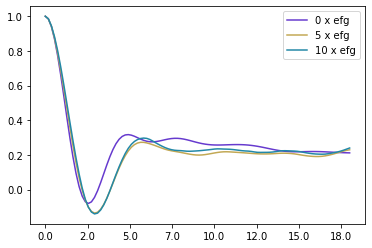

In [5]:
fig, axes = plt.subplots(1,1)
for i, Bmod in enumerate(efgray):
    color = list(np.random.choice(range(256), size=3)/256)
    axes.plot(tlist, signals[i], label='{} x efg'.format(Bmod*1), linestyle='-', color=color)
#axes.set_ylim((-0.5,1.1))
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticklabels(ticks)
plt.legend()
plt.show()

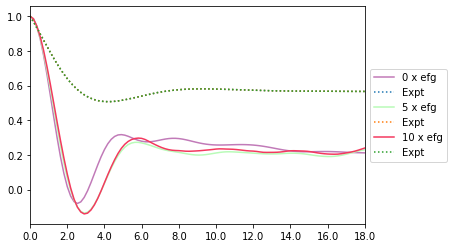

In [6]:
# from scipy.io import loadmat
# import matplotlib.ticker as ticker
# f=loadmat('v3ge-expt.mat')
# t0=f['t']
# y0=f['y']
# t=t0[0]*1e-6
# y=y0[0]/0.2191
# fig, axes = plt.subplots(1,1)
# for i, Bmod in enumerate(efgray):
#     color = list(np.random.choice(range(256), size=3)/256)
#     axes.plot(tlist, signals[i], label='{} x efg'.format(Bmod*1), linestyle='-', color=color)
#     axes.plot(t,y, label='Expt', linestyle=':')
# #axes.set_ylim((-0.3,1.1))
# axes.set_xlim((0.,max(tlist)))
# ticks = np.round(axes.get_xticks()*10.**6)
# axes.set_xticklabels(ticks)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

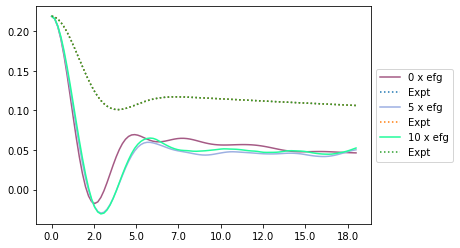

In [7]:
## the bamuba function
sys.path.insert(0, '/home/misah/PARMA/WORK/undi-master/examples/v3ge/')
#import bamuba as b
from bamuba import plot_bamuba
tlist0 = np.linspace(0, 18, 1000)
y=plot_bamuba(tlist0)
fig, axes = plt.subplots(1,1)
#for i, Bmod in enumerate(efgray):
color = list(np.random.choice(range(256), size=3)/256)
axes.plot(tlist, signal_Cu*0.2191, label='{} x efg'.format(0*1), linestyle='-', color=color)
axes.plot(tlist0*1e-6,y, label='Expt', linestyle=':')
#axes.set_ylim((-0.3,1.1))
#axes.set_xlim((0.,max(tlist)))
ticks = np.round(axes.get_xticks()*10.**6)
axes.set_xticklabels(ticks)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()